# Recommendations with IBM

In this notebook, you will be putting your recommendation skills to use on real data from the IBM Watson Studio platform. 


You may either submit your notebook through the workspace here, or you may work from your local machine and submit through the next page.  Either way assure that your code passes the project [RUBRIC](https://review.udacity.com/#!/rubrics/2322/view).  **Please save regularly.**

By following the table of contents, you will build out a number of different methods for making recommendations that can be used for different situations. 


## Table of Contents

I. [Exploratory Data Analysis](#Exploratory-Data-Analysis)<br>
II. [Rank Based Recommendations](#Rank)<br>
III. [User-User Based Collaborative Filtering](#User-User)<br>
IV. [Content Based Recommendations (EXTRA - NOT REQUIRED)](#Content-Recs)<br>
V. [Matrix Factorization](#Matrix-Fact)<br>
VI. [Extras & Concluding](#conclusions)

At the end of the notebook, you will find directions for how to submit your work.  Let's get started by importing the necessary libraries and reading in the data.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import project_tests as t
import pickle
import itertools

%matplotlib inline

df = pd.read_csv('data/user-item-interactions.csv')
df_content = pd.read_csv('data/articles_community.csv')
df_content_2 = pd.read_csv('data/articles_community.csv', dtype=str)
del df['Unnamed: 0']
del df_content['Unnamed: 0']
del df_content_2['Unnamed: 0']
# Show df to get an idea of the data
df.head()

,article_id,title,email
0,1430.0,"using pixiedust for fast, flexible, and easier...",ef5f11f77ba020cd36e1105a00ab868bbdbf7fe7
1,1314.0,healthcare python streaming application demo,083cbdfa93c8444beaa4c5f5e0f5f9198e4f9e0b
2,1429.0,use deep learning for image classification,b96a4f2e92d8572034b1e9b28f9ac673765cd074
3,1338.0,ml optimization using cognitive assistant,06485706b34a5c9bf2a0ecdac41daf7e7654ceb7
4,1276.0,deploy your python model as a restful api,f01220c46fc92c6e6b161b1849de11faacd7ccb2


In [2]:
# Show df_content to get an idea of the data
df_content.head()

,doc_body,doc_description,doc_full_name,doc_status,article_id
0,Skip navigation Sign in SearchLoading...\r\n\r...,Detect bad readings in real time using Python ...,Detect Malfunctioning IoT Sensors with Streami...,Live,0
1,No Free Hunch Navigation * kaggle.com\r\n\r\n ...,"See the forest, see the trees. Here lies the c...",Communicating data science: A guide to present...,Live,1
2,☰ * Login\r\n * Sign Up\r\n\r\n * Learning Pat...,Here’s this week’s news in Data Science and Bi...,"This Week in Data Science (April 18, 2017)",Live,2
3,"DATALAYER: HIGH THROUGHPUT, LOW LATENCY AT SCA...",Learn how distributed DBs solve the problem of...,DataLayer Conference: Boost the performance of...,Live,3
4,Skip navigation Sign in SearchLoading...\r\n\r...,This video demonstrates the power of IBM DataS...,Analyze NY Restaurant data using Spark in DSX,Live,4


### <a class="anchor" id="Exploratory-Data-Analysis">Part I : Exploratory Data Analysis</a>

Use the dictionary and cells below to provide some insight into the descriptive statistics of the data.

`1.` What is the distribution of how many articles a user interacts with in the dataset?  Provide a visual and descriptive statistics to assist with giving a look at the number of times each user interacts with an article.  

In [3]:
df.describe()

,article_id
count,45993.000000
mean,908.846477
std,486.647866
min,0.000000
25%,460.000000
50%,1151.000000
75%,1336.000000
max,1444.000000


In [4]:
df.email.value_counts()

2b6c0f514c2f2b04ad3c4583407dccd0810469ee    364
77959baaa9895a7e2bdc9297f8b27c1b6f2cb52a    363
2f5c7feae533ce046f2cb16fb3a29fe00528ed66    170
a37adec71b667b297ed2440a9ff7dad427c7ac85    169
8510a5010a5d4c89f5b07baac6de80cd12cfaf93    160
f8c978bcf2ae2fb8885814a9b85ffef2f54c3c76    158
284d0c17905de71e209b376e3309c0b08134f7e2    148
18e7255ee311d4bd78f5993a9f09538e459e3fcc    147
d9032ff68d0fd45dfd18c0c5f7324619bb55362c    147
c60bb0a50c324dad0bffd8809d121246baef372b    145
276d9d8ca0bf52c780b5a3fc554fa69e74f934a3    145
56832a697cb6dbce14700fca18cffcced367057f    144
b2d2c70ed5de62cf8a1d4ded7dd141cfbbdd0388    142
ceef2a24a2a82031246814b73e029edba51e8ea9    140
8dc8d7ec2356b1b106eb3d723f3c234e03ab3f1e    137
e38f123afecb40272ba4c47cb25c96a9533006fa    136
53db7ac77dbb80d6f5c32ed5d19c1a8720078814    132
6c14453c049b1ef4737b08d56c480419794f91c2    131
fd824fc62b4753107e3db7704cd9e8a4a1c961f1    116
c45f9495a76bf95d2633444817f1be8205ad542d    114
12bb8a9740400ced27ae5a7d4c990ac3b7e3c77d

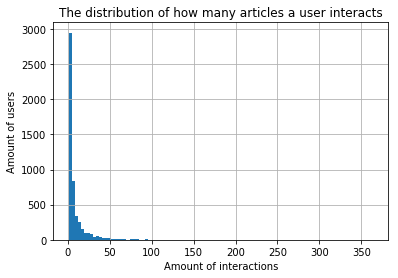

In [5]:
# The distribution of how many articles a user interacts.
df.email.value_counts().hist(bins=100)
plt.title('The distribution of how many articles a user interacts')
plt.xlabel('Amount of interactions')
plt.ylabel('Amount of users')
plt.show()

In [6]:
import statistics
find_50 = statistics.median(df.email.value_counts())
find_50

3.0

In [7]:
df.article_id.value_counts()

1429.0    937
1330.0    927
1431.0    671
1427.0    643
1364.0    627
1314.0    614
1293.0    572
1170.0    565
1162.0    512
1304.0    483
1436.0    481
1271.0    473
1398.0    465
43.0      460
1351.0    457
1393.0    455
1185.0    442
1160.0    433
1354.0    426
1368.0    418
1305.0    413
1338.0    382
1336.0    379
1165.0    372
1172.0    363
151.0     352
1276.0    347
1432.0    340
1430.0    336
1052.0    330
         ... 
1208.0      2
778.0       2
1283.0      2
1135.0      2
1210.0      2
430.0       2
416.0       2
1251.0      2
1227.0      2
1230.0      2
1086.0      2
1156.0      2
1266.0      1
653.0       1
1233.0      1
1127.0      1
1092.0      1
1119.0      1
675.0       1
724.0       1
1237.0      1
1202.0      1
1344.0      1
662.0       1
1200.0      1
974.0       1
417.0       1
1113.0      1
984.0       1
1072.0      1
Name: article_id, Length: 714, dtype: int64

In [8]:
df_content.describe()

,article_id
count,1056.000000
mean,523.913826
std,303.480641
min,0.000000
25%,260.750000
50%,523.500000
75%,786.250000
max,1050.000000


In [9]:
df_content['article_id'].value_counts().sum()


1056

In [10]:
df_content['article_id']

0          0
1          1
2          2
3          3
4          4
5          5
6          6
7          7
8          8
9          9
10        10
11        11
12        12
13        13
14        14
15        15
16        16
17        17
18        18
19        19
20        20
21        21
22        22
23        23
24        24
25        25
26        26
27        27
28        28
29        29
        ... 
1026    1021
1027    1022
1028    1023
1029    1024
1030    1025
1031    1026
1032    1027
1033    1028
1034    1029
1035    1030
1036    1031
1037    1032
1038    1033
1039    1034
1040    1035
1041    1036
1042    1037
1043    1038
1044    1039
1045    1040
1046    1041
1047    1042
1048    1043
1049    1044
1050    1045
1051    1046
1052    1047
1053    1048
1054    1049
1055    1050
Name: article_id, Length: 1056, dtype: int64

In [11]:
# There are a total of 1056 articles listed in the dataset but a total of 1051 articles. (articles start at label 0)  
# So there are some duplicates.

In [12]:
df_content['doc_status'].value_counts()

Live    1056
Name: doc_status, dtype: int64

In [13]:
df_content[(df_content['doc_status'] != 'Live')].count()

doc_body           0
doc_description    0
doc_full_name      0
doc_status         0
article_id         0
dtype: int64

In [14]:
# The documents are all live

In [15]:
# Fill in the median and maximum number of user_article interactios below

median_val = 3 # 50% of individuals interact with __3__ number of articles or fewer.
max_views_by_user = 364 # The maximum number of user-article interactions by any 1 user is __364____.

`2.` Explore and remove duplicate articles from the **df_content** dataframe.  

In [16]:
# Find and explore duplicate articles
df_content['article_id'].duplicated().value_counts()

False    1051
True        5
Name: article_id, dtype: int64

In [17]:
df_content[df_content[['article_id']].duplicated() == True]

,doc_body,doc_description,doc_full_name,doc_status,article_id
365,Follow Sign in / Sign up Home About Insight Da...,During the seven-week Insight Data Engineering...,Graph-based machine learning,Live,50
692,Homepage Follow Sign in / Sign up Homepage * H...,One of the earliest documented catalogs was co...,How smart catalogs can turn the big data flood...,Live,221
761,Homepage Follow Sign in Get started Homepage *...,Today’s world of data science leverages data f...,Using Apache Spark as a parallel processing fr...,Live,398
970,This video shows you how to construct queries ...,This video shows you how to construct queries ...,Use the Primary Index,Live,577
971,Homepage Follow Sign in Get started * Home\r\n...,"If you are like most data scientists, you are ...",Self-service data preparation with IBM Data Re...,Live,232


In [18]:
# Remove any rows that have the same article_id - only keep the first

In [19]:
#drop duplicates
df_content.drop_duplicates(keep='first', inplace=True)
df_content.drop_duplicates(subset=['article_id'], keep='first', inplace=True)
df_content.shape

(1051, 5)

`3.` Use the cells below to find:

**a.** The number of unique articles that have an interaction with a user.  
**b.** The number of unique articles in the dataset (whether they have any interactions or not).<br>
**c.** The number of unique users in the dataset. (excluding null values) <br>
**d.** The number of user-article interactions in the dataset.

In [20]:
# user-article = df
# unique = df_content


In [21]:
df['email'].isnull().value_counts()

False    45976
True        17
Name: email, dtype: int64

In [22]:
na_drop = df.dropna(axis=0)
print (na_drop.groupby('email')['title'].transform('count') >= 1)

0        True
1        True
2        True
3        True
4        True
5        True
6        True
7        True
8        True
9        True
10       True
11       True
12       True
13       True
14       True
15       True
16       True
17       True
18       True
19       True
20       True
21       True
22       True
23       True
24       True
25       True
26       True
27       True
28       True
29       True
         ... 
45963    True
45964    True
45965    True
45966    True
45967    True
45968    True
45969    True
45970    True
45971    True
45972    True
45973    True
45974    True
45975    True
45976    True
45977    True
45978    True
45979    True
45980    True
45981    True
45982    True
45983    True
45984    True
45985    True
45986    True
45987    True
45988    True
45989    True
45990    True
45991    True
45992    True
Name: title, Length: 45976, dtype: bool


In [23]:
print ((na_drop.groupby('email')['title'].transform('count') >= 1).value_counts())

True    45976
Name: title, dtype: int64


In [24]:
# The number of user-article interactions
df.article_id.value_counts().sum()

45993

In [25]:
# The number of unique users
array = na_drop['email'].unique()
len(na_drop['email'].unique().tolist())


5148

In [26]:
# The number of unique articles that have at least one interaction
len(df['title'].unique().tolist())


714

In [27]:
# The number of unique articles on the IBM platform
len(df_content['doc_full_name'].unique().tolist())

1051

In [28]:
na_drop.email.value_counts().sum()

45976

In [29]:
unique_articles = int(714) # The number of unique articles that have at least one interaction
total_articles = int(1051) # The number of unique articles on the IBM platform
unique_users = int(5148) # The number of unique users
user_article_interactions = int(45993) # The number of user-article interactions

`4.` Use the cells below to find the most viewed **article_id**, as well as how often it was viewed.  After talking to the company leaders, the `email_mapper` function was deemed a reasonable way to map users to ids.  There were a small number of null values, and it was found that all of these null values likely belonged to a single user (which is how they are stored using the function below).

In [30]:
df.article_id.value_counts()

1429.0    937
1330.0    927
1431.0    671
1427.0    643
1364.0    627
1314.0    614
1293.0    572
1170.0    565
1162.0    512
1304.0    483
1436.0    481
1271.0    473
1398.0    465
43.0      460
1351.0    457
1393.0    455
1185.0    442
1160.0    433
1354.0    426
1368.0    418
1305.0    413
1338.0    382
1336.0    379
1165.0    372
1172.0    363
151.0     352
1276.0    347
1432.0    340
1430.0    336
1052.0    330
         ... 
1208.0      2
778.0       2
1283.0      2
1135.0      2
1210.0      2
430.0       2
416.0       2
1251.0      2
1227.0      2
1230.0      2
1086.0      2
1156.0      2
1266.0      1
653.0       1
1233.0      1
1127.0      1
1092.0      1
1119.0      1
675.0       1
724.0       1
1237.0      1
1202.0      1
1344.0      1
662.0       1
1200.0      1
974.0       1
417.0       1
1113.0      1
984.0       1
1072.0      1
Name: article_id, Length: 714, dtype: int64

In [31]:
df.query('article_id == 1429.0').head()

,article_id,title,email
2,1429.0,use deep learning for image classification,b96a4f2e92d8572034b1e9b28f9ac673765cd074
6,1429.0,use deep learning for image classification,3c2de1b0a92728aa53064a22ff7bd7319878ed95
41,1429.0,use deep learning for image classification,b96a4f2e92d8572034b1e9b28f9ac673765cd074
75,1429.0,use deep learning for image classification,3c2de1b0a92728aa53064a22ff7bd7319878ed95
80,1429.0,use deep learning for image classification,d385b6c44711688ce2a33eb596495bf9243e1750


In [32]:
most_viewed_article_id = str('1429.0')  # The most viewed article in the dataset as a string with one value following the decimal 
max_views = 937# The most viewed article in the dataset was viewed how many times?

In [33]:
## No need to change the code here - this will be helpful for later parts of the notebook
# Run this cell to map the user email to a user_id column and remove the email column

def email_mapper():
    coded_dict = dict()
    cter = 1
    email_encoded = []
    
    for val in df['email']:
        if val not in coded_dict:
            coded_dict[val] = cter
            cter+=1
        
        email_encoded.append(coded_dict[val])
    return email_encoded

email_encoded = email_mapper()
del df['email']
df['user_id'] = email_encoded

# show header
df.head()

,article_id,title,user_id
0,1430.0,"using pixiedust for fast, flexible, and easier...",1
1,1314.0,healthcare python streaming application demo,2
2,1429.0,use deep learning for image classification,3
3,1338.0,ml optimization using cognitive assistant,4
4,1276.0,deploy your python model as a restful api,5


In [34]:
df.title.value_counts().head()

use deep learning for image classification                      937
insights from new york car accident reports                     927
visualize car data with brunel                                  671
use xgboost, scikit-learn & ibm watson machine learning apis    643
predicting churn with the spss random tree algorithm            627
Name: title, dtype: int64

In [35]:
df.article_id.value_counts().head()

1429.0    937
1330.0    927
1431.0    671
1427.0    643
1364.0    627
Name: article_id, dtype: int64

In [36]:
## If you stored all your results in the variable names above, 
## you shouldn't need to change anything in this cell

sol_1_dict = {
    '`50% of individuals have _____ or fewer interactions.`': median_val,
    '`The total number of user-article interactions in the dataset is ______.`': user_article_interactions,
    '`The maximum number of user-article interactions by any 1 user is ______.`': max_views_by_user,
    '`The most viewed article in the dataset was viewed _____ times.`': max_views,
    '`The article_id of the most viewed article is ______.`': most_viewed_article_id,
    '`The number of unique articles that have at least 1 rating ______.`': unique_articles,
    '`The number of unique users in the dataset is ______`': unique_users,
    '`The number of unique articles on the IBM platform`': total_articles
}

# Test your dictionary against the solution
t.sol_1_test(sol_1_dict)

It looks like you have everything right here! Nice job!


### <a class="anchor" id="Rank">Part II: Rank-Based Recommendations</a>

Unlike in the earlier lessons, we don't actually have ratings for whether a user liked an article or not.  We only know that a user has interacted with an article.  In these cases, the popularity of an article can really only be based on how often an article was interacted with.

`1.` Fill in the function below to return the **n** top articles ordered with most interactions as the top. Test your function using the tests below.

In [37]:
top_articles = []
new_list = df.title.value_counts()
new_list = pd.DataFrame(new_list)




In [38]:
for index, row in new_list.head(n=5).iterrows():
     print(index)

use deep learning for image classification
insights from new york car accident reports
visualize car data with brunel
use xgboost, scikit-learn & ibm watson machine learning apis
predicting churn with the spss random tree algorithm


In [39]:
def get_top_articles(n, df=df):
    '''
    INPUT:
    n - (int) the number of top articles to return
    df - (pandas dataframe) df as defined at the top of the notebook 
    
    OUTPUT:
    top_articles - (list) A list of the top 'n' article titles 
    
    '''
    # Your code here
    top_articles = []
    new_list = df.title.value_counts()
    new_list = pd.DataFrame(new_list)
    for index, row in new_list.head(n=n).iterrows():
        top_articles.append(str(index))
    return top_articles # Return the top article titles from df (not df_content)



def get_top_article_ids(n, df=df):
    '''
    INPUT:
    n - (int) the number of top articles to return
    df - (pandas dataframe) df as defined at the top of the notebook 
    
    OUTPUT:
    top_articles - (list) A list of the top 'n' article titles 
    
    '''
    # Your code here
    top_articles_id = []
    new_list = df.title.value_counts()
    new_list = pd.DataFrame(new_list)
    for index, row in new_list.head(n=n).iterrows():
        id_look = df[df['title'] == index]['article_id'].iloc[0]
        top_articles_id.append(id_look)
    return top_articles_id # Return the top article ids

In [40]:
print(get_top_articles(10))
print(get_top_article_ids(10))


['use deep learning for image classification', 'insights from new york car accident reports', 'visualize car data with brunel', 'use xgboost, scikit-learn & ibm watson machine learning apis', 'predicting churn with the spss random tree algorithm', 'healthcare python streaming application demo', 'finding optimal locations of new store using decision optimization', 'apache spark lab, part 1: basic concepts', 'analyze energy consumption in buildings', 'gosales transactions for logistic regression model']
[1429.0, 1330.0, 1431.0, 1427.0, 1364.0, 1314.0, 1293.0, 1170.0, 1162.0, 1304.0]


In [41]:
# Test your function by returning the top 5, 10, and 20 articles
top_5 = get_top_articles(5)
top_10 = get_top_articles(10)
top_20 = get_top_articles(20)

# Test each of your three lists from above
t.sol_2_test(get_top_articles)

Your top_5 looks like the solution list! Nice job.
Your top_10 looks like the solution list! Nice job.
Your top_20 looks like the solution list! Nice job.


### <a class="anchor" id="User-User">Part III: User-User Based Collaborative Filtering</a>


`1.` Use the function below to reformat the **df** dataframe to be shaped with users as the rows and articles as the columns.  

* Each **user** should only appear in each **row** once.


* Each **article** should only show up in one **column**.  


* **If a user has interacted with an article, then place a 1 where the user-row meets for that article-column**.  It does not matter how many times a user has interacted with the article, all entries where a user has interacted with an article should be a 1.  


* **If a user has not interacted with an item, then place a zero where the user-row meets for that article-column**. 

Use the tests to make sure the basic structure of your matrix matches what is expected by the solution.

In [42]:
df.head()

,article_id,title,user_id
0,1430.0,"using pixiedust for fast, flexible, and easier...",1
1,1314.0,healthcare python streaming application demo,2
2,1429.0,use deep learning for image classification,3
3,1338.0,ml optimization using cognitive assistant,4
4,1276.0,deploy your python model as a restful api,5


In [43]:
# create the user-article matrix with 1's and 0's

def create_user_item_matrix(df):
    '''
    INPUT:
    df - pandas dataframe with article_id, title, user_id columns
    
    OUTPUT:
    user_item - user item matrix 
    
    Description:
    Return a matrix with user ids as rows and article ids on the columns with 1 values where a user interacted with 
    an article and a 0 otherwise
    '''
    # Create user-by-item matrix
    df_new=df.groupby(['article_id', 'user_id']).count().reset_index()
    df_new=df_new.pivot_table(index='user_id',columns='article_id',values='title')
    df_new = df_new.replace(np.nan, 0)
    user_item=df_new.applymap(lambda x: 1 if x > 0 else x)
    
    return user_item# return the user_item matrix


user_item = create_user_item_matrix(df)
user_item.head()


article_id,0.0,2.0,4.0,8.0,9.0,12.0,14.0,15.0,16.0,18.0,...,1434.0,1435.0,1436.0,1437.0,1439.0,1440.0,1441.0,1442.0,1443.0,1444.0
user_id,,,,,,,,,,,,,,,,,,,,,
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [44]:
## Tests: You should just need to run this cell.  Don't change the code.
assert user_item.shape[0] == 5149, "Oops!  The number of users in the user-article matrix doesn't look right."
assert user_item.shape[1] == 714, "Oops!  The number of articles in the user-article matrix doesn't look right."
assert user_item.sum(axis=1)[1] == 36, "Oops!  The number of articles seen by user 1 doesn't look right."
print("You have passed our quick tests!  Please proceed!")

You have passed our quick tests!  Please proceed!


`2.` Complete the function below which should take a user_id and provide an ordered list of the most similar users to that user (from most similar to least similar).  The returned result should not contain the provided user_id, as we know that each user is similar to him/herself. Because the results for each user here are binary, it (perhaps) makes sense to compute similarity as the dot product of two users. 

Use the tests to test your function.

In [45]:
def find_similar_users(user_id, user_item=user_item):
    '''
    INPUT:
    user_id - (int) a user_id
    user_item - (pandas dataframe) matrix of users by articles: 
                1's when a user has interacted with an article, 0 otherwise
    
    OUTPUT:
    similar_users - (list) an ordered list where the closest users (largest dot product users)
                    are listed first
    
    Description:
    Computes the similarity of every pair of users based on the dot product
    Returns an ordered
    
    '''
    # compute similarity of each user to the provided user
    num_users = user_item.shape[0]
    user_vector = user_item.loc[user_id] 
    
    users_tile = np.tile(user_vector.values, (num_users, 1)) 
    
    # compute similarity of each user to the provided user
    similarities = np.multiply(users_tile, user_item).sum(axis = 1) 
    
    # sort by similarity
    similarities.sort_values(ascending=False, inplace = True)
    
    # create list of just the ids
    most_similar_users = list(similarities.index)
    
    # remove the own user's id
    most_similar_users.remove(user_id)
    
    return most_similar_users # return a list of the users in order from most to least similar
        

In [46]:
# Do a spot check of your function
print("The 10 most similar users to user 1 are: {}".format(find_similar_users(1)[:10]))
print("The 5 most similar users to user 3933 are: {}".format(find_similar_users(3933)[:5]))
print("The 3 most similar users to user 46 are: {}".format(find_similar_users(46)[:3]))

The 10 most similar users to user 1 are: [3933, 23, 3782, 203, 4459, 131, 3870, 46, 4201, 5041]
The 5 most similar users to user 3933 are: [1, 23, 3782, 4459, 203]
The 3 most similar users to user 46 are: [4201, 23, 3782]


`3.` Now that you have a function that provides the most similar users to each user, you will want to use these users to find articles you can recommend.  Complete the functions below to return the articles you would recommend to each user. 

In [47]:
df.query('1338.0')['title']

'connect to db2 warehouse on cloud and db2 using scala'

In [48]:
article_names = (df[df['article_id'] == 2]['title']
                     .drop_duplicates().values.tolist())
article_names

['this week in data science (april 18, 2017)']

In [49]:
def get_article_names(article_ids, df=df):
    '''
    INPUT:
    article_ids - (list) a list of article ids
    df - (pandas dataframe) df as defined at the top of the notebook
    
    OUTPUT:
    article_names - (list) a list of article names associated with the list of article ids 
                    (this is identified by the title column)
    '''
    article_names = []
    for id in article_ids:
        title = df[df['article_id'] == float(id)]['title'].iloc[0]
        article_names.append(title)
    
    # Return the article names associated with list of article ids
    return article_names 

In [50]:
def get_article_names(article_ids, df=df):
    '''
    INPUT:
    article_ids - (list) a list of article ids
    df - (pandas dataframe) df as defined at the top of the notebook
    
    OUTPUT:
    article_names - (list) a list of article names associated with the list of article ids 
                    (this is identified by the title column)
    '''
    articleID_titles = df.drop_duplicates('article_id').drop('user_id', axis=1).set_index('article_id')
  
    # convert strings of article names into floats (because thats the data type of the index)
    article_ids_float = list(map(float, article_ids))
    
    article_names = articleID_titles.loc[article_ids_float, 'title'].values
    
    return article_names # Return the article names associated with list of article ids

def get_user_articles(user_id, user_item=user_item):
    '''
    INPUT:
    user_id - (int) a user id
    user_item - (pandas dataframe) matrix of users by articles: 
                1's when a user has interacted with an article, 0 otherwise
    
    OUTPUT:
    article_ids - (list) a list of the article ids seen by the user
    article_names - (list) a list of article names associated with the list of article ids 
                    (this is identified by the doc_full_name column in df_content)
    
    Description:
    Provides a list of the article_ids and article titles that have been seen by a user
    '''
    
    # Find all the user ids that a certain user has seen

    article_ids = user_item.loc[user_id][user_item.loc[user_id] == 1].index.tolist()
    for x in range(0, len(article_ids)):
        article_ids[x] = str(article_ids[x])
        
    article_names = get_article_names(article_ids)
    return article_ids, article_names # return the ids and names


def user_user_recs(user_id, m=10):
    '''
    INPUT:
    user_id - (int) a user id
    m - (int) the number of recommendations you want for the user
    
    OUTPUT:
    recs - (list) a list of recommendations for the user
    
    Description:
    Loops through the users based on closeness to the input user_id
    For each user - finds articles the user hasn't seen before and provides them as recs
    Does this until m recommendations are found
    
    Notes:
    Users who are the same closeness are chosen arbitrarily as the 'next' user
    
    For the user where the number of recommended articles starts below m 
    and ends exceeding m, the last items are chosen arbitrarily
    
    '''
    
    # Find all articles that the user has read before
    user_read_articles = get_user_articles(user_id)[0]
    similar_users = find_similar_users(user_id)

    # Find all articles that has been read by the similiar users
    read_articles = [get_user_articles(user)[0] for user in similar_users]
    read_articles_list = list(itertools.chain.from_iterable(read_articles))

    # remove duplicated read articles
    read_articles_unique = pd.Series(read_articles_list).drop_duplicates().tolist()

    # remove articles that has been seen by the given user, use the remaining articles as recommendations
    recs = [i for i in read_articles_unique if i not in user_read_articles][:m]
    
    return recs



In [51]:
user_user_recs(1, 10)

['2.0', '12.0', '14.0', '16.0', '26.0', '28.0', '29.0', '33.0', '50.0', '74.0']

In [52]:
# Check Results
get_article_names(user_user_recs(1, 10)) # Return 10 recommendations for user 1

array(['this week in data science (april 18, 2017)',
       'timeseries data analysis of iot events by using jupyter notebook',
       'got zip code data? prep it for analytics. – ibm watson data lab – medium',
       'higher-order logistic regression for large datasets',
       'using machine learning to predict parking difficulty',
       'deep forest: towards an alternative to deep neural networks',
       'experience iot with coursera',
       'using brunel in ipython/jupyter notebooks',
       'graph-based machine learning',
       'the 3 kinds of context: machine learning and the art of the frame'], dtype=object)

In [53]:
get_article_names(['1024.0', '1176.0', '1305.0', '1314.0', '1422.0', '1427.0'])

array(['using deep learning to reconstruct high-resolution audio',
       'build a python app on the streaming analytics service',
       'gosales transactions for naive bayes model',
       'healthcare python streaming application demo',
       'use r dataframes & ibm watson natural language understanding',
       'use xgboost, scikit-learn & ibm watson machine learning apis'], dtype=object)

In [54]:
# Test your functions here - No need to change this code - just run this cell
assert set(get_article_names(['1024.0', '1176.0', '1305.0', '1314.0', '1422.0', '1427.0'])) == set(['using deep learning to reconstruct high-resolution audio', 'build a python app on the streaming analytics service', 'gosales transactions for naive bayes model', 'healthcare python streaming application demo', 'use r dataframes & ibm watson natural language understanding', 'use xgboost, scikit-learn & ibm watson machine learning apis']), "Oops! Your the get_article_names function doesn't work quite how we expect."
assert set(get_article_names(['1320.0', '232.0', '844.0'])) == set(['housing (2015): united states demographic measures','self-service data preparation with ibm data refinery','use the cloudant-spark connector in python notebook']), "Oops! Your the get_article_names function doesn't work quite how we expect."
assert set(get_user_articles(20)[0]) == set(['1320.0', '232.0', '844.0'])
assert set(get_user_articles(20)[1]) == set(['housing (2015): united states demographic measures', 'self-service data preparation with ibm data refinery','use the cloudant-spark connector in python notebook'])
assert set(get_user_articles(2)[0]) == set(['1024.0', '1176.0', '1305.0', '1314.0', '1422.0', '1427.0'])
assert set(get_user_articles(2)[1]) == set(['using deep learning to reconstruct high-resolution audio', 'build a python app on the streaming analytics service', 'gosales transactions for naive bayes model', 'healthcare python streaming application demo', 'use r dataframes & ibm watson natural language understanding', 'use xgboost, scikit-learn & ibm watson machine learning apis'])
print("If this is all you see, you passed all of our tests!  Nice job!")

If this is all you see, you passed all of our tests!  Nice job!


`4.` Now we are going to improve the consistency of the **user_user_recs** function from above.  

* Instead of arbitrarily choosing when we obtain users who are all the same closeness to a given user - choose the users that have the most total article interactions before choosing those with fewer article interactions.


* Instead of arbitrarily choosing articles from the user where the number of recommended articles starts below m and ends exceeding m, choose articles with the articles with the most total interactions before choosing those with fewer total interactions. This ranking should be  what would be obtained from the **top_articles** function you wrote earlier.

In [55]:
user_item.index

Int64Index([   1,    2,    3,    4,    5,    6,    7,    8,    9,   10,
            ...
            5140, 5141, 5142, 5143, 5144, 5145, 5146, 5147, 5148, 5149],
           dtype='int64', name='user_id', length=5149)

In [56]:
def get_top_sorted_users(user_id, df=df, user_item=user_item):
    '''
    INPUT:
    user_id - (int)
    df - (pandas dataframe) df as defined at the top of the notebook 
    user_item - (pandas dataframe) matrix of users by articles: 
            1's when a user has interacted with an article, 0 otherwise
    
            
    OUTPUT:
    neighbors_df - (pandas dataframe) a dataframe with:
                    neighbor_id - is a neighbor user_id
                    similarity - measure of the similarity of each user to the provided user_id
                    num_interactions - the number of articles viewed by the user - if a u
                    
    Other Details - sort the neighbors_df by the similarity and then by number of interactions where 
                    highest of each is higher in the dataframe
     
    '''
    # Your code here
    colName = ['neighbor_id', 'similarity', 'num_interactions']
    neighbors_df  = pd.DataFrame(columns= colName)

    for id in user_item.index.values:
        if id != user_id:
            neighbor_id = id
            # Getting user-to-user similarity number
            similarity = user_item[user_item.index == user_id].dot(user_item.loc[id].transpose()).values[0]
            # Number of interactions for user-to-article
            num_interactions = user_item.loc[id].values.sum()
            neighbors_df.loc[neighbor_id] = [neighbor_id, similarity, num_interactions]
    
    neighbors_df['similarity'] = neighbors_df['similarity'].astype('int')
    neighbors_df['neighbor_id'] = neighbors_df['neighbor_id'].astype('int')
    neighbors_df = neighbors_df.sort_values(by = ['similarity', 'neighbor_id'], ascending = [False, True])
    
    return neighbors_df # Return the dataframe specified in the doc_string



def user_user_recs_part2(user_id, m=10):
    '''
    INPUT:
    user_id - (int) a user id
    m - (int) the number of recommendations you want for the user
    
    OUTPUT:
    recs - (list) a list of recommendations for the user by article id
    rec_names - (list) a list of recommendations for the user by article title
    
    Description:
    Loops through the users based on closeness to the input user_id
    For each user - finds articles the user hasn't seen before and provides them as recs
    Does this until m recommendations are found
    
    Notes:
    * Choose the users that have the most total article interactions 
    before choosing those with fewer article interactions.

    * Choose articles with the articles with the most total interactions 
    before choosing those with fewer total interactions. 
   
    '''
    # Your code here
    user_read_articles = get_user_articles(user_id)[0]
    similar_users = get_top_sorted_users(user_id)['neighbor_id'].values.tolist()
    
    # Find all articles that has been read by the similiar users
    read_articles = [get_user_articles(user)[0] for user in similar_users]
    read_articles_list = list(itertools.chain.from_iterable(read_articles))
    
    # remove duplicated read articles
    read_articles_unique = pd.Series(read_articles_list).drop_duplicates().tolist()

    # remove articles that has been seen by the given user, use the remaining articles as recommendations
    recs = [i for i in read_articles_unique if i not in user_read_articles][:m]
    rec_names = get_article_names(recs)
    
    return recs, rec_names

In [57]:
get_top_sorted_users(user_id = 2, df=df, user_item=user_item).head()

,neighbor_id,similarity,num_interactions
49,49,5,101.0
98,98,5,97.0
3697,3697,5,100.0
3764,3764,5,97.0
10,10,4,19.0


In [58]:
user_user_recs_part2(user_id = 2, m=10)

(['8.0',
  '16.0',
  '34.0',
  '40.0',
  '50.0',
  '53.0',
  '59.0',
  '74.0',
  '92.0',
  '111.0'],
 array(['data science bowl 2017',
        'higher-order logistic regression for large datasets',
        'top 10 machine learning use cases: part 1',
        'ensemble learning to improve machine learning results',
        'graph-based machine learning', 'introducing streams designer',
        '20405    how to tame the valley — hessian-free hacks fo...\nName: title, dtype: object',
        'the 3 kinds of context: machine learning and the art of the frame',
        '9 mistakes to avoid when starting your career in data science',
        'tidy up your jupyter notebooks with scripts'], dtype=object))

In [59]:
# Quick spot check - don't change this code - just use it to test your functions
rec_ids, rec_names = user_user_recs_part2(20, 10)
print("The top 10 recommendations for user 20 are the following article ids:")
print(rec_ids)
print()
print("The top 10 recommendations for user 20 are the following article names:")
print(rec_names)

The top 10 recommendations for user 20 are the following article ids:
['43.0', '109.0', '111.0', '112.0', '164.0', '213.0', '225.0', '313.0', '337.0', '379.0']

The top 10 recommendations for user 20 are the following article names:
['deep learning with tensorflow course by big data university'
 'tensorflow quick tips' 'tidy up your jupyter notebooks with scripts'
 'building custom machine learning algorithms with apache systemml'
 'learn tensorflow and deep learning together and now!'
 'modeling energy usage in new york city'
 'a visual explanation of the back propagation algorithm for neural networks'
 'what is machine learning?' 'generalization in deep learning'
 'data structures related to machine learning algorithms']


`5.` Use your functions from above to correctly fill in the solutions to the dictionary below.  Then test your dictionary against the solution.  Provide the code you need to answer each following the comments below.

In [60]:
rec_ids, rec_names = user_user_recs_part2(1, 10)
print(rec_ids)
print(rec_names)

['2.0', '12.0', '14.0', '16.0', '26.0', '28.0', '29.0', '33.0', '50.0', '74.0']
['this week in data science (april 18, 2017)'
 'timeseries data analysis of iot events by using jupyter notebook'
 'got zip code data? prep it for analytics. – ibm watson data lab – medium'
 'higher-order logistic regression for large datasets'
 'using machine learning to predict parking difficulty'
 'deep forest: towards an alternative to deep neural networks'
 'experience iot with coursera' 'using brunel in ipython/jupyter notebooks'
 'graph-based machine learning'
 'the 3 kinds of context: machine learning and the art of the frame']


In [61]:
get_top_sorted_users(user_id = 1, df=df, user_item=user_item).head(10).head()

,neighbor_id,similarity,num_interactions
3933,3933,35,35.0
23,23,17,135.0
3782,3782,17,135.0
203,203,15,96.0
4459,4459,15,96.0


In [62]:
rec_ids, rec_names = user_user_recs_part2(131, 10)
print(rec_ids)
print(rec_names)

['195.0', '2.0', '16.0', '26.0', '28.0', '29.0', '33.0', '43.0', '50.0', '76.0']
[ 'artificial intelligence, ethically speaking – inside machine learning – medium'
 'this week in data science (april 18, 2017)'
 'higher-order logistic regression for large datasets'
 'using machine learning to predict parking difficulty'
 'deep forest: towards an alternative to deep neural networks'
 'experience iot with coursera' 'using brunel in ipython/jupyter notebooks'
 'deep learning with tensorflow course by big data university'
 'graph-based machine learning' 'this week in data science (may 2, 2017)']


In [63]:
get_top_sorted_users(user_id = 131, df=df, user_item=user_item).head(10)

,neighbor_id,similarity,num_interactions
3870,3870,74,75.0
3782,3782,39,135.0
23,23,38,135.0
203,203,33,96.0
4459,4459,33,96.0
49,49,29,101.0
98,98,29,97.0
3697,3697,29,100.0
3764,3764,29,97.0
242,242,25,59.0


In [64]:
### Tests with a dictionary of results

user1_most_sim = 3933 # Find the user that is most similar to user 1 
user131_10th_sim = 242 # Find the 10th most similar user to user 131

In [65]:
## Dictionary Test Here
sol_5_dict = {
    'The user that is most similar to user 1.': user1_most_sim, 
    'The user that is the 10th most similar to user 131': user131_10th_sim,
}

t.sol_5_test(sol_5_dict)

This all looks good!  Nice job!


In [66]:
sol_5_dict

{'The user that is most similar to user 1.': 3933,
 'The user that is the 10th most similar to user 131': 242}

`6.` If we were given a new user, which of the above functions would you be able to use to make recommendations?  Explain.  Can you think of a better way we might make recommendations?  Use the cell below to explain a better method for new users.

**I could use all of the functions, however, none of the would do me any good.  I would need prior knowledge of the user's interactions or desired interests.  This information is what I use to make any comparisons between users and articles. What I could do is recommend the top articles from every user**

`7.` Using your existing functions, provide the top 10 recommended articles you would provide for the a new user below.  You can test your function against our thoughts to make sure we are all on the same page with how we might make a recommendation.

In [67]:
print(get_top_articles(10))
print(get_top_article_ids(10))

['use deep learning for image classification', 'insights from new york car accident reports', 'visualize car data with brunel', 'use xgboost, scikit-learn & ibm watson machine learning apis', 'predicting churn with the spss random tree algorithm', 'healthcare python streaming application demo', 'finding optimal locations of new store using decision optimization', 'apache spark lab, part 1: basic concepts', 'analyze energy consumption in buildings', 'gosales transactions for logistic regression model']
[1429.0, 1330.0, 1431.0, 1427.0, 1364.0, 1314.0, 1293.0, 1170.0, 1162.0, 1304.0]


In [68]:
new_user = '0.0'

# What would your recommendations be for this new user '0.0'?  As a new user, they have no observed articles.
# Provide a list of the top 10 article ids you would give to 

# 10 most popular articles
new_user_recs = get_top_article_ids(10)

# Convert ids to strings to match the test in the next cell
new_user_recs = [str(id) for id in new_user_recs]


In [69]:
assert set(new_user_recs) == set(['1314.0','1429.0','1293.0','1427.0','1162.0','1364.0','1304.0','1170.0','1431.0','1330.0']), "Oops!  It makes sense that in this case we would want to recommend the most popular articles, because we don't know anything about these users."

print("That's right!  Nice job!")

That's right!  Nice job!


### <a class="anchor" id="Content-Recs">Part IV: Content Based Recommendations (EXTRA - NOT REQUIRED)</a>

Another method we might use to make recommendations is to perform a ranking of the highest ranked articles associated with some term.  You might consider content to be the **doc_body**, **doc_description**, or **doc_full_name**.  There isn't one way to create a content based recommendation, especially considering that each of these columns hold content related information.  

`1.` Use the function body below to create a content based recommender.  Since there isn't one right answer for this recommendation tactic, no test functions are provided.  Feel free to change the function inputs if you decide you want to try a method that requires more input values.  The input values are currently set with one idea in mind that you may use to make content based recommendations.  One additional idea is that you might want to choose the most popular recommendations that meet your 'content criteria', but again, there is a lot of flexibility in how you might make these recommendations.

### This part is NOT REQUIRED to pass this project.  However, you may choose to take this on as an extra way to show off your skills.

In [70]:
#clean up the columns, we don't need extra unnecessary columns
df_content_2 = df_content_2.drop(columns='doc_status')

In [72]:
# import more statements for the new content based functions
import pandas as pd
from rake_nltk import Rake # must install: https://pypi.org/project/rake-nltk/, pip install rake-nltk
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.feature_extraction.text import CountVectorizer
import re
import nltk


In [73]:
'''# putting the genres in a list of words
df_content['doc_description'] = str(df_content['doc_description'])
df_content['doc_description'] = df_content['doc_description'].map(lambda x: x.split(','))

letters_only = re.sub("[^a-zA-Z]",  # Search for all non-letters
                          " ",          # Replace all non-letters with spaces
                          str(df_content['doc_description']))'''

'# putting the genres in a list of words\ndf_content[\'doc_description\'] = str(df_content[\'doc_description\'])\ndf_content[\'doc_description\'] = df_content[\'doc_description\'].map(lambda x: x.split(\',\'))\n\nletters_only = re.sub("[^a-zA-Z]",  # Search for all non-letters\n                          " ",          # Replace all non-letters with spaces\n                          str(df_content[\'doc_description\']))'

In [74]:
df_content['doc_description'] = df_content['doc_description'].astype(str)

In [75]:
# df_content_2 must be in str/object form and not int for the next functions to work
after = df_content_2.dtypes 
after

doc_body           object
doc_description    object
doc_full_name      object
article_id         object
dtype: object

In [76]:
# find the key words in the data columns that will be used. 
# Use the Rake function to extract key words from the column, 
def get_key_words(existing_column, column_to_add):
    '''
    INPUT: existing_column - columns desired to clean and find key words
    
    OUTPUT: column_to_add - a new column in the dataframe that will have the key words
            df_content_2 - modified dataframe
    
    '''
    # initializing the new column
    df_content_2[column_to_add] = ''
    df_content_2[existing_column] = df_content_2[existing_column].astype(str)

    for index, row in df_content_2.iterrows():
        plot = row[existing_column]
    
        # instantiating Rake, by default is uses english stopwords from NLTK
        # and discard all puntuation characters
        r = Rake()
    
        # extracting the words by passing the text
        r.extract_keywords_from_text(plot)

        # getting the dictionary whith key words as keys and their scores as values
        key_words_dict_scores = r.get_word_degrees() #r.get_ranked_phrases()
    
        # assigning the key words to the new column for the corresponding movie
        row[column_to_add] = list(key_words_dict_scores.keys())

    # dropping the Plot column
    df_content_2.drop(columns = [existing_column], inplace = True)
    print(df_content_2[column_to_add].head())
    return df_content_2

In [77]:
# find key words for column: doc_full_name
key_name_1 = get_key_words('doc_full_name', 'Key_words_2')

0    [streaming, analytics, detect, malfunctioning,...
1    [presenting, communicating, data, science, wor...
2               [week, 2017, data, science, april, 18]
3    [boost, distributed, database, datalayer, conf...
4    [analyze, ny, restaurant, data, using, spark, ...
Name: Key_words_2, dtype: object


In [78]:
# find key words for column: doc_description
key_name_2 = get_key_words('doc_description', 'Key_words')

0    [streaming, analytics, real, time, using, pyth...
1    [see, performing, data, scientists, fulfilling...
2                  [’, week, big, data, science, news]
3    [scaling, persistent, storage, learn, data, si...
4    [simple, new, york, state, restaurant, inspect...
Name: Key_words, dtype: object


In [79]:
# find key words for column: doc_body
key_name_3 = get_key_words('doc_body', 'Key_words_3')

0    [notebook, demonstrated, loading, ..., watch, ...
1    [proceeding, know, work, 4communicating, data,...
2    [top, mistakes, data, scientists, make, parkin...
3    [single, server, dbs, data, size, increases, a...
4    [safety, loading, ..., watch, queue, __count__...
Name: Key_words_3, dtype: object


In [80]:
df_content_2.head()

,article_id,Key_words_2,Key_words,Key_words_3
0,0,"[streaming, analytics, detect, malfunctioning,...","[streaming, analytics, real, time, using, pyth...","[notebook, demonstrated, loading, ..., watch, ..."
1,1,"[presenting, communicating, data, science, wor...","[see, performing, data, scientists, fulfilling...","[proceeding, know, work, 4communicating, data,..."
2,2,"[week, 2017, data, science, april, 18]","[’, week, big, data, science, news]","[top, mistakes, data, scientists, make, parkin..."
3,3,"[boost, distributed, database, datalayer, conf...","[scaling, persistent, storage, learn, data, si...","[single, server, dbs, data, size, increases, a..."
4,4,"[analyze, ny, restaurant, data, using, spark, ...","[simple, new, york, state, restaurant, inspect...","[safety, loading, ..., watch, queue, __count__..."


In [81]:
df_content_2.set_index('article_id', inplace = True)
df_content_2.head()

,Key_words_2,Key_words,Key_words_3
article_id,,,
0,"[streaming, analytics, detect, malfunctioning,...","[streaming, analytics, real, time, using, pyth...","[notebook, demonstrated, loading, ..., watch, ..."
1,"[presenting, communicating, data, science, wor...","[see, performing, data, scientists, fulfilling...","[proceeding, know, work, 4communicating, data,..."
2,"[week, 2017, data, science, april, 18]","[’, week, big, data, science, news]","[top, mistakes, data, scientists, make, parkin..."
3,"[boost, distributed, database, datalayer, conf...","[scaling, persistent, storage, learn, data, si...","[single, server, dbs, data, size, increases, a..."
4,"[analyze, ny, restaurant, data, using, spark, ...","[simple, new, york, state, restaurant, inspect...","[safety, loading, ..., watch, queue, __count__..."


In [82]:
# combine all the columns into a bag of words
# get rid of [] and ,
df_content_2['bag_of_words'] = ''
columns = df_content_2.columns
for index, row in df_content_2.iterrows():
    words = ''
    for col in columns:
        if col != 'article_id':
            words = words + ' '.join(row[col])+ ' '
        else:
            words = words + row[col]+ ' '
    row['bag_of_words'] = words
    
df_content_2.drop(columns = [col for col in df_content_2.columns if col!= 'bag_of_words'], inplace = True)

In [83]:
# new bag of words dataframe
df_content_2.head()

,bag_of_words
article_id,
0,streaming analytics detect malfunctioning iot ...
1,presenting communicating data science work gui...
2,week 2017 data science april 18 ’ week big dat...
3,boost distributed database datalayer conferenc...
4,analyze ny restaurant data using spark dsx sim...


In [84]:
# The dot product is related to similarity and is part of the definition in regards to vectors u and v.
# The definition of similarity between two vectors u and v is, in fact,
# the ratio between their dot product and the product of their magnitudes.

# instantiating and generating the count matrix
count = CountVectorizer()
count_matrix = count.fit_transform(df_content_2['bag_of_words'])

# generating the cosine similarity matrix
cosine_sim = cosine_similarity(count_matrix, count_matrix)
cosine_sim

array([[ 1.        ,  0.10825749,  0.14062317, ...,  0.12679915,
         0.10514995,  0.10959932],
       [ 0.10825749,  1.        ,  0.18470865, ...,  0.21635112,
         0.0534833 ,  0.18605368],
       [ 0.14062317,  0.18470865,  1.        , ...,  0.14966903,
         0.08703883,  0.13608276],
       ..., 
       [ 0.12679915,  0.21635112,  0.14966903, ...,  1.        ,
         0.04484711,  0.17669533],
       [ 0.10514995,  0.0534833 ,  0.08703883, ...,  0.04484711,
         1.        ,  0.08528029],
       [ 0.10959932,  0.18605368,  0.13608276, ...,  0.17669533,
         0.08528029,  1.        ]])

In [85]:
# Creating a Series for the df_content_2 - article_ids, they will be associated by ordered numerical values, 
# with the top dot products appering first in a output
indices = pd.Series(df_content_2.index)

#  defining the function that takes in movie title 
# as input and returns the top 10 recommended movies
def recommendations_index(article, cosine_sim = cosine_sim):
    '''
    INPUT: article - the article_id of a row
        `cosine_sim - 
    
    OUTPUT: recommended - a list with the top 10 similar matching article_ids
    
    '''
    # initializing the empty list of recommended movies
    recommended = []
    
    # getting the index 
    idx = article 

    # creating a Series with the similarity scores in descending order
    score_series = pd.Series(cosine_sim[idx]).sort_values(ascending = False)

    # getting the indexes of the 10 most similar
    top_10_indexes = list(score_series.iloc[1:11].index)
    
    # populating the list with the index of the best 10 matching 
    for i in top_10_indexes:
        recommended.append(list(df.index)[i])
        
    return recommended

In [86]:
# see if the function works, try article_id 1
recommendations_index(1)

[728, 32, 101, 980, 724, 1011, 92, 124, 791, 619]

In [87]:
# convert recommendations_index output numbers to the document title names
def get_document_names_from_rec(article_ids, df=df):
    '''
    INPUT:
    article_ids - (list) a list of article ids
    df - (pandas dataframe) df as defined at the top of the notebook
    
    OUTPUT:
    article_names - (list) a list of document names associated with the list of article ids 
                    (this is identified by the title column)
    '''
    
    document_names = df_content.loc[article_ids]['doc_full_name']
    
    return document_names # Return the document names associated with list of article ids

In [88]:
get_document_names_from_rec(728)

'May 2016: Scripts of the Week'

In [89]:
get_document_names_from_rec(recommendations_index(1))

728                         May 2016: Scripts of the Week
32        A Kaggler's Guide to Model Stacking in Practice
101      How to choose a project to practice data science
980                              The Data Science Process
724                            Visual Information Theory 
1011    Essentials of Machine Learning Algorithms (wit...
92      9 Mistakes to Avoid When Starting Your Career ...
124        Python Machine Learning: Scikit-Learn Tutorial
791     Quick Guide to Build a Recommendation Engine i...
619                 Can A.I. Be Taught to Explain Itself?
Name: doc_full_name, dtype: object

`2.` Now that you have put together your content-based recommendation system, use the cell below to write a summary explaining how your content based recommender works.  Do you see any possible improvements that could be made to your function?  Is there anything novel about your content based recommender?

### This part is NOT REQUIRED to pass this project.  However, you may choose to take this on as an extra way to show off your skills.

**explanation: Essentially this processes uses a quick form of nltk to find key words. These key words are summed per row then mulitpled by each other column with cosine_similarity.  By applying the definition of cosine_similarity being similarity with regards to u and v, the results will be equal to 1 if the two vectors are identical, and it will be 0 if the two are orthogonal. In simple terms, the similarity is a number between 0 and 1 that tells us how much the two vectors are similar.  The next function sorts the closest values to the inputed value and get their names.**  

**Nothing is really novel about this approach beside using rake_nltk which is a simpler form for nltk.  An improvment would be to create a terminal application that could easily do these steps without much effort.  Another improvment would be to use Soft Cosine Similarity.  This function metric gives higher scores for words belonging to the same topic and lower scores when comparing words from different topics.  To find Soft Cosine Similarity, look up the  module gensim.matutils for this.** 

`3.` Use your content-recommendation system to make recommendations for the below scenarios based on the comments.  Again no tests are provided here, because there isn't one right answer that could be used to find these content based recommendations.

### This part is NOT REQUIRED to pass this project.  However, you may choose to take this on as an extra way to show off your skills.

In [90]:
# make recommendations for a brand new user


# make a recommendations for a user who only has interacted with article id '1427.0'



### <a class="anchor" id="Matrix-Fact">Part V: Matrix Factorization</a>

In this part of the notebook, you will build use matrix factorization to make article recommendations to the users on the IBM Watson Studio platform.

`1.` You should have already created a **user_item** matrix above in **question 1** of **Part III** above.  This first question here will just require that you run the cells to get things set up for the rest of **Part V** of the notebook. 

In [91]:
# Load the matrix here
user_item_matrix = pd.read_pickle('user_item_matrix.p')

In [92]:
# quick look at the matrix
user_item_matrix.head()

article_id,0.0,100.0,1000.0,1004.0,1006.0,1008.0,101.0,1014.0,1015.0,1016.0,...,977.0,98.0,981.0,984.0,985.0,986.0,990.0,993.0,996.0,997.0
user_id,,,,,,,,,,,,,,,,,,,,,
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


`2.` In this situation, you can use Singular Value Decomposition from [numpy](https://docs.scipy.org/doc/numpy-1.14.0/reference/generated/numpy.linalg.svd.html) on the user-item matrix.  Use the cell to perform SVD, and explain why this is different than in the lesson.

In [93]:
# Perform SVD on the User-Item Matrix Here

u, s, vt = np.linalg.svd(user_item_matrix, full_matrices=True, compute_uv=True) # use the built in to get the three matrices

**In the lessons, the built-in method did not support matrices with missing values.  Hence FunkSVD was used to fix this problem. However, in this notebook, there is a matrix with all 1-0 values. Therefore, the built-in works for this matrix, because it has no missing values.**

`3.` Now for the tricky part, how do we choose the number of latent features to use?  Running the below cell, you can see that as the number of latent features increases, we obtain a lower error rate on making predictions for the 1 and 0 values in the user-item matrix.  Run the cell below to get an idea of how the accuracy improves as we increase the number of latent features.

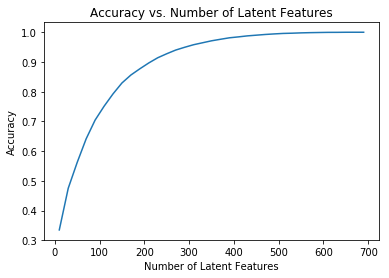

In [94]:
num_latent_feats = np.arange(10,700+10,20)
sum_errs = []

for k in num_latent_feats:
    # restructure with k latent features
    s_new, u_new, vt_new = np.diag(s[:k]), u[:, :k], vt[:k, :]
    
    # take dot product
    user_item_est = np.around(np.dot(np.dot(u_new, s_new), vt_new))
    
    # compute error for each prediction to actual value
    diffs = np.subtract(user_item_matrix, user_item_est)
    
    # total errors and keep track of them
    err = np.sum(np.sum(np.abs(diffs)))
    sum_errs.append(err)
    
    
plt.plot(num_latent_feats, 1 - np.array(sum_errs)/df.shape[0]);
plt.xlabel('Number of Latent Features');
plt.ylabel('Accuracy');
plt.title('Accuracy vs. Number of Latent Features');

`4.` From the above, we can't really be sure how many features to use, because simply having a better way to predict the 1's and 0's of the matrix doesn't exactly give us an indication of if we are able to make good recommendations.  Instead, we might split our dataset into a training and test set of data, as shown in the cell below.  

Use the code from question 3 to understand the impact on accuracy of the training and test sets of data with different numbers of latent features. Using the split below: 

* How many users can we make predictions for in the test set?  
* How many users are we not able to make predictions for because of the cold start problem?
* How many articles can we make predictions for in the test set?  
* How many articles are we not able to make predictions for because of the cold start problem?

In [95]:
df_train = df.head(40000)
df_test = df.tail(5993)

def create_test_and_train_user_item(df_train, df_test):
    '''
    INPUT:
    df_train - training dataframe
    df_test - test dataframe
    
    OUTPUT:
    user_item_train - a user-item matrix of the training dataframe 
                      (unique users for each row and unique articles for each column)
    user_item_test - a user-item matrix of the testing dataframe 
                    (unique users for each row and unique articles for each column)
    test_idx - all of the test user ids
    test_arts - all of the test article ids
    
    '''
    # Your code here
    
    user_item_train = create_user_item_matrix(df_train)
    
    user_item_test = create_user_item_matrix(df_test)

        
    test_idx = list(set(user_item_test.index))
    test_arts = list(set(user_item_test.columns))
        
    return user_item_train, user_item_test, test_idx, test_arts

user_item_train, user_item_test, test_idx, test_arts = create_test_and_train_user_item(df_train, df_test)

In [96]:
len(set(user_item_train.index))

4487

In [97]:
len(test_idx)

682

In [98]:
# How many users can we make predictions for in the test set?
len(set(user_item_test.index) & set(user_item_train.index))

20

In [99]:
# How many users in the test set are we not able to make predictions for because of the cold start problem?
len(set(user_item_test.index) - set(user_item_train.index))

662

In [100]:
len(test_arts)

574

In [101]:
# How many articles can we make predictions for in the test set?
len(set(user_item_test.columns) & set(user_item_train.columns))

574

In [102]:
# How many articles in the test set are we not able to make predictions for because of the cold start problem
len(set(user_item_test.columns) - set(user_item_train.columns))

0

In [103]:
# Replace the values in the dictionary below
a = 662 
b = 574 
c = 20 
d = 0 


sol_4_dict = {
    'How many users can we make predictions for in the test set?': c , 
    'How many users in the test set are we not able to make predictions for because of the cold start problem?': a , 
    'How many movies can we make predictions for in the test set?': b ,
    'How many movies in the test set are we not able to make predictions for because of the cold start problem?': d 
}

t.sol_4_test(sol_4_dict)

Awesome job!  That's right!  All of the test movies are in the training data, but there are only 20 test users that were also in the training set.  All of the other users that are in the test set we have no data on.  Therefore, we cannot make predictions for these users using SVD.


In [104]:
# fit SVD on the user_item_train matrix
u_train, s_train, vt_train = np.linalg.svd(user_item_train, full_matrices=False) # fit svd similar to above then use the cells below
u_train.shape, s_train.shape, vt_train.shape

((4487, 714), (714,), (714, 714))

In [105]:
# Use these cells to see how well you can use the training 
# decomposition to predict on test data

In [106]:
row_idxs = user_item_train.index.isin(test_idx)
col_idxs = user_item_train.columns.isin(test_arts)
u_test = u_train[row_idxs, :]
vt_test = vt_train[:, col_idxs]
u_test.shape, vt_test.shape

((20, 714), (714, 574))

In [107]:
# find the subset of users and articles from user_item_test that we could predict.
test_users = set(user_item_train.index) & set(user_item_test.index)
test_articles = set(user_item_train.columns) & set(user_item_test.columns)
user_item_test_could_pred = user_item_test.loc[test_users, test_articles]

In [108]:
from sklearn.metrics import f1_score
num_latent_feats = np.arange(10,700,20)

sum_errs_train = []
sum_errs_test = []

f1_train = []
f1_test = []

for k in num_latent_feats:
    # restructure with k latent features
    s_train_new, u_train_new, vt_train_new = np.diag(s_train[:k]), u_train[:, :k], vt_train[:k, :]
    u_test_new, vt_test_new = u_test[:, :k], vt_test[:k, :]
    
    # take dot product
    user_item_train_est = np.around(np.dot(np.dot(u_train_new, s_train_new), vt_train_new))
    user_item_test_est = np.around(np.dot(np.dot(u_test_new, s_train_new), vt_test_new))
    
    # compute error for each prediction to actual value
    diffs_train = np.subtract(user_item_train, user_item_train_est)
    diffs_test = np.subtract(user_item_test_could_pred, user_item_test_est)
    
    # total errors and keep track of them
    sum_errs_train.append(np.sum(np.sum(np.abs(diffs_train))))
    sum_errs_test.append(np.sum(np.sum(np.abs(diffs_test))))
    
    # compute f1 score (macro) for each prediction to actual value
    f1_train.append(f1_score(np.array(user_item_train).flatten(), user_item_train_est.flatten(), labels=[1.0], average='macro'))
    f1_test.append(f1_score(np.array(user_item_test_could_pred).flatten(), user_item_test_est.flatten(), labels=[1.0], average='macro'))

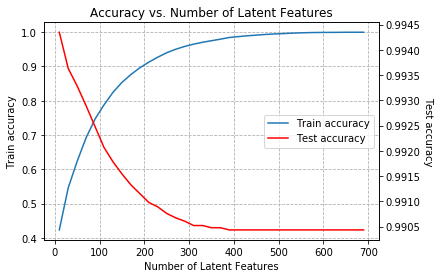

In [109]:
fig, ax1 = plt.subplots()
ax2 = ax1.twinx()

ax1.plot(num_latent_feats, 1 - np.array(sum_errs_train)/df.shape[0], label="Train accuracy")
ax2.plot(num_latent_feats, 1 - np.array(sum_errs_test)/df.shape[0], color='red', label="Test accuracy")

handler1, label1 = ax1.get_legend_handles_labels()
handler2, label2 = ax2.get_legend_handles_labels()

ax1.legend(handler1+handler2, label1+label2, loc='center right')

ax1.set_title('Accuracy vs. Number of Latent Features')
ax1.grid(linestyle='--')

ax1.set_xlabel('Number of Latent Features')
ax1.set_ylabel('Train accuracy')
ax2.set_ylabel('Test accuracy', rotation=270, labelpad=12)

plt.show()

**Training accuracy and testing accuracy have an inverse rleationship in regards to added latent features.**

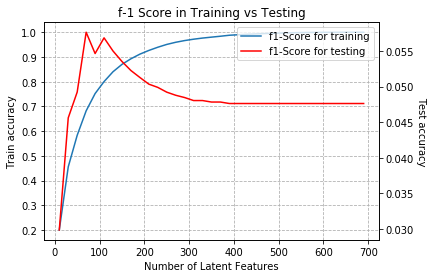

In [110]:
fig, ax1 = plt.subplots()
ax2 = ax1.twinx()

ax1.plot(num_latent_feats, f1_train, label='f1-Score for training')
ax2.plot(num_latent_feats, f1_test, color='red', label='f1-Score for testing')

#ax1.plot(num_latent_feats, 1 - np.array(f1_train)/df.shape[0], label='f1-Score for training')
#ax2.plot(num_latent_feats, 1 - np.array(f1_test)/df.shape[0], color='green', label='f1-Score for testing')

handle1, label1 = ax1.get_legend_handles_labels()
handle2, label2 = ax2.get_legend_handles_labels()

ax1.legend(handle1+handle2, label1+label2, loc='upper right')

ax1.set_title('f-1 Score in Training vs Testing')
ax1.grid(linestyle='--')

ax1.set_xlabel('Number of Latent Features')
ax1.set_ylabel('Train accuracy')
ax2.set_ylabel('Test accuracy', rotation=270, labelpad=12)

plt.show()

`6.` Use the cell below to comment on the results you found in the previous question. Given the circumstances of your results, discuss what you might do to determine if the recommendations you make with any of the above recommendation systems are an improvement to how users currently find articles? 

**The optimal number of latent featuers for testing is between 0-100 features.  After about 100 latent features, testing accuracy f1-score decreases.  At the 350 mark of latent features for testing, accuracy levels off at the lowest point. A good f1-score by definition means perfect precision and recall.  So at about 100 latent features that  is the nearest area of perfect precision and recall**

<a id='conclusions'></a>
### Extras
Using your workbook, you could now save your recommendations for each user, develop a class to make new predictions and update your results, and make a flask app to deploy your results.  These tasks are beyond what is required for this project.  However, from what you learned in the lessons, you certainly capable of taking these tasks on to improve upon your work here!


## Conclusion

> Congratulations!  You have reached the end of the Recommendations with IBM project! 

> **Tip**: Once you are satisfied with your work here, check over your report to make sure that it is satisfies all the areas of the [rubric](https://review.udacity.com/#!/rubrics/2322/view). You should also probably remove all of the "Tips" like this one so that the presentation is as polished as possible.


## Directions to Submit

> Before you submit your project, you need to create a .html or .pdf version of this notebook in the workspace here. To do that, run the code cell below. If it worked correctly, you should get a return code of 0, and you should see the generated .html file in the workspace directory (click on the orange Jupyter icon in the upper left).

> Alternatively, you can download this report as .html via the **File** > **Download as** submenu, and then manually upload it into the workspace directory by clicking on the orange Jupyter icon in the upper left, then using the Upload button.

> Once you've done this, you can submit your project by clicking on the "Submit Project" button in the lower right here. This will create and submit a zip file with this .ipynb doc and the .html or .pdf version you created. Congratulations! 

In [111]:
from subprocess import call
call(['python', '-m', 'nbconvert', 'Recommendations_with_IBM.ipynb'])

0

# Resources


In [ ]:
# Referenced to help build a content recommender function:
    # https://towardsdatascience.com/how-to-build-from-scratch-a-content-based-movie-recommender-with-natural-language-processing-25ad400eb243

# Udacity Class Lectures
